In [5]:
import gym
import gym_inventory
from gym_inventory.envs.inventory_env import InventoryEnv
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

class InventoryManager:
    def __init__(self, max_inventory, cost_order, cost_item, cost_holding, price_item, lam):
        self.env = InventoryEnv(n=max_inventory, k=cost_order, c=cost_item, h=cost_holding, p=price_item, lam=lam)
        self.P = self.calculate_transition_probabilities()

    def calculate_transition_probabilities(self):
        P = np.zeros((self.env.n + 1, self.env.n + 1, self.env.n + 1))
        for s in range(self.env.n + 1):
            for a in range(self.env.n + 1):
                P[s, a] = self.transition_probability(s, a)
        return P

    def transition_probability(self, state, action):
        p = np.zeros(self.env.n + 1)
        for demand in range(self.env.n + 1):
            next_state = self.env.transition(state, action, demand)
            if next_state >= 0 and next_state <= self.env.n:
                p[next_state] += poisson.pmf(demand, self.env.lam)
        p = np.round(p, decimals=2)
        return p



    def policy_evaluation(self, policy, gamma=0.9, theta=0.00001):
        V = np.zeros(self.env.n + 1)
        while True:
            delta = 0
            for s in range(self.env.n + 1):
                v = V[s]
                new_v = 0
                for a in range(self.env.n + 1):
                    for s_prime in range(self.env.n + 1):
                        reward = self.env.reward(s, a, s_prime)
                        new_v += policy[s, a] * self.P[s, a, s_prime] * (reward + gamma * V[s_prime])
                V[s] = new_v
                delta = max(delta, np.abs(v - V[s]))
            if delta < theta:
                break
        return V

    def policy_iteration(self, gamma=0.9, theta=0.00001):
        policy = np.ones((self.env.n + 1, self.env.n + 1)) / (self.env.n + 1)  # Initialize with a random policy

        while True:
            V = self.policy_evaluation(policy, gamma, theta)

            policy_stable = True
            for s in range(self.env.n + 1):
                old_action = np.argmax(policy[s])
                action_values = [np.sum(self.P[s, a, s_prime] * (self.env.reward(s, a, s_prime) + gamma * V[s_prime]) for s_prime in range(self.env.n + 1)) for a in range(self.env.n + 1)]
                best_action = np.argmax(action_values)

                if old_action != best_action:
                    policy_stable = False
                policy[s] = np.eye(self.env.n + 1)[best_action]

            if policy_stable:
                break

        return policy, V
   

    def value_iteration(self, gamma=0.9, theta=0.00001):
        V = np.zeros(self.env.n + 1)
        
        while True:
            delta = 0
            for s in range(self.env.n + 1):
                v = V[s]
                action_values = np.zeros(self.env.n + 1)
                for a in range(self.env.n + 1):
                    for s_prime in range(self.env.n + 1):
                        reward = self.env.reward(s, a, s_prime) 
                        action_values[a] += self.P[s, a, s_prime] * (reward + gamma * V[s_prime])
                V[s] = np.max(action_values)
                delta = max(delta, np.abs(v - V[s]))
            if delta < theta:
                break
                
        policy = np.zeros((self.env.n+1, self.env.n+1))
        for s in range(self.env.n + 1):
            action_values = np.zeros(self.env.n + 1)
            for a in range(self.env.n + 1):
                for s_prime in range(self.env.n + 1):
                    reward = self.env.reward(s, a, s_prime)
                    action_values[a] += self.P[s, a, s_prime] * (reward + gamma * V[s_prime])
            policy[s, np.argmax(action_values)] = 1
            
        return policy, V
    
    def visualize(self, optimal_policy, optimal_value):
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        ax[0].bar(range(self.env.n + 1), np.argmax(optimal_policy, axis=1))
        ax[0].set_title("Optimal Policy")
        ax[0].set_xlabel("Inventory Level")
        ax[0].set_ylabel("Order Quantity")

        ax[1].bar(range(self.env.n + 1), optimal_value)
        ax[1].set_title("Optimal Value Function")
        ax[1].set_xlabel("Inventory Level")
        ax[1].set_ylabel("Value")

        plt.show()
    



/tmp/ipykernel_369825/1859009538.py:57: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  action_values = [np.sum(self.P[s, a, s_prime] * (self.env.reward(s, a, s_prime) + gamma * V[s_prime]) for s_prime in range(self.env.n + 1)) for a in range(self.env.n + 1)]


Optimal Policy:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

Optimal Value Function:
[423.27995027 424.27995347 425.27995412 426.27995475 427.27995538
 428.279956   429.27995654 430.27995699 431.27995736 432.27995766
 433.27995788 434.27995803 435.27995817 436.27995825 437.27995832
 438.27995832 439.27995832 440.27995832 441.27995832 442.27995832
 443.27995832 444.27995832 445.27995832 446.27995832 448.39495695
 449.93795737 451.23295783 452.27995832 453.1099588  453.75395927
 451.57696014 454.57696014 454.78696054 454.90396089 454.9589612
 454.95196147 455.66451659 456.67451659 459.70451659 459.6494387
 454.59753122 454.53045328 454.47453532 454.43075834 454.37443537
 454.35090838 454.30814841 454.28870744 454.22828951 454.13861261
 454.01582972]


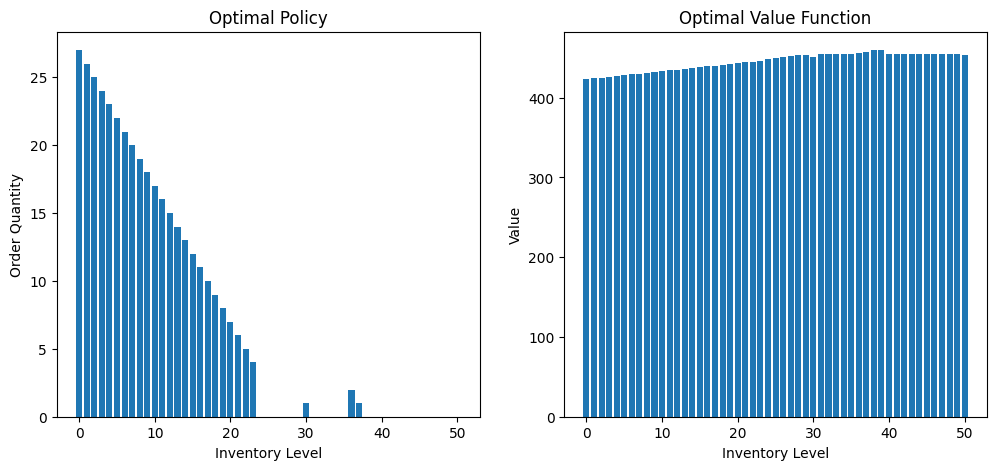

In [9]:
###### policy_iteration
max_inventory = 50
cost_order = 2
cost_item = 2
cost_holding = 1
price_item = 4
lam = 25

inventory_policy_iteration = InventoryManager(max_inventory, cost_order, cost_item, cost_holding, price_item, lam)
optimal_policy, optimal_value = inventory_policy_iteration.policy_iteration()
print("Optimal Policy:")
print(optimal_policy)
print("\nOptimal Value Function:")
print(optimal_value)

inventory_policy_iteration.visualize(optimal_policy, optimal_value)


Optimal Policy:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

Optimal Value Function:
[423.27995548 424.27995835 425.27995893 426.2799595  427.27996006
 428.27996061 429.27996109 430.2799615  431.27996183 432.2799621
 433.2799623  434.27996243 435.27996256 436.27996262 437.27996269
 438.27996269 439.27996269 440.27996269 441.27996269 442.27996269
 443.27996269 444.27996269 445.27996269 446.27996269 448.39496146
 449.93796184 451.23296225 452.27996269 453.10996312 453.75396354
 451.57696432 454.57696432 454.78696468 454.90396499 454.95896526
 454.95196551 455.66452062 456.67452062 459.70452062 459.64944271
 454.59753518 454.53045723 454.47453927 454.43076229 454.37443931
 454.35091233 454.30815235 454.28871138 454.22829344 454.13861653
 454.01583363]


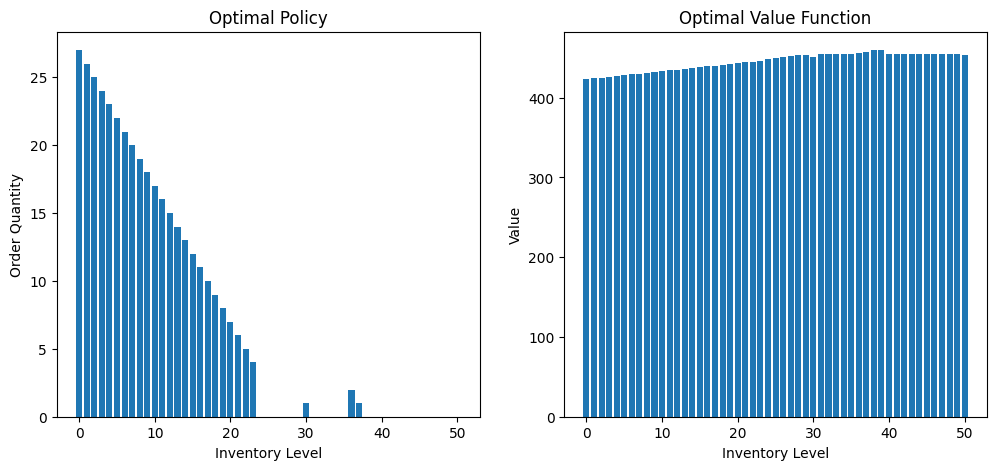

In [8]:
    
### VALUE ITERATION
max_inventory = 50
cost_order = 2
cost_item = 2
cost_holding = 1
price_item = 4
lam = 25


inventory_policy_iteration = InventoryManager(max_inventory, cost_order, cost_item, cost_holding, price_item, lam)
optimal_policy, optimal_value = inventory_policy_iteration.value_iteration()

print("Optimal Policy:")
print(optimal_policy)
print("\nOptimal Value Function:")
print(optimal_value)

inventory_policy_iteration.visualize(optimal_policy, optimal_value)